In [1]:
import torch

In [2]:
# getting a dataset

import json
import os
import urllib


def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    # The book originally contained this unnecessary "else" clause:
    #else:
    #    with open(file_path, "r", encoding="utf-8") as file:
    #        text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "./instruction_data/instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [3]:
# this is based on a older, more widespread approach
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input\n{entry['input']}" if entry['input'] else ""

    return instruction_text + input_text

In [4]:
# creating data fortrain, val and test
train_portion = int(len(data) * 0.85)
test_portion = int(len(data) * 0.1)
val_portion = len(data) - train_portion - test_portion

train_data = data[:train_portion]
test_data = data[train_portion:train_portion+test_portion]
val_data = data[-val_portion:]


In [5]:
print(len(val_data))
print(len(train_data))
print(len(test_data))

55
935
110


In [6]:
# need to pad the inputs to have always the same size in each batch

def custom_collate(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=1024, device="cpu"):

    # get longest sequence in the batch
    batch_longest = max(len(item)+1 for item in batch)

    input_padd_list, target_padd_list = [], []
    for item in batch:
        new_item = item.copy()

        padded = new_item + [pad_token_id] * (batch_longest - len(new_item))

        inputs = torch.tensor(padded[:-1])
        targets = torch.tensor(padded[1:])

        # need to replace all but one end-of-text token with the ignore index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1: # more than one end of text token"
            targets[indices[1:]] = ignore_index

        # make sure the tokens fit the model's context length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]

        # temporary ??
        input_padd_list.append(inputs)
        target_padd_list.append(targets)

    # stack the list onto a single tensor and return the input data
    return torch.stack(input_padd_list).to(device), torch.stack(target_padd_list).to(device)

In [7]:
# test the collage function
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

inp, trg = custom_collate(batch)

In [8]:
import tiktoken

from classes.dataloader import DataLoader
from classes.dataset import InstructionDataset

torch.manual_seed(123)

batch_size= 8
num_workers = 0

train_dataset = InstructionDataset(train_data, tiktoken.get_encoding("gpt2"))
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tiktoken.get_encoding("gpt2"))
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tiktoken.get_encoding("gpt2"))
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=custom_collate,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

In [9]:
# Define model configurations in a dictionary for compactness
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# base configurations
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False,
    "gpt_model_name": "",
    "gpt_num_params": ""
}

# Copy the base configuration and update with specific model settings
model_name = "gpt2-medium (355M)"  # Example model name
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})
NEW_CONFIG.update({"gpt_model_name": model_name, "gpt_num_params": "355M" })

from classes.model import GPTModel

# Create the new model using the properties from the selected gpt model
model = GPTModel(NEW_CONFIG)
model.eval();

# Load the gpt weights into the model
model.load_weights_gpt()

File already exists and is up-to-date: gpt2\355M\checkpoint
File already exists and is up-to-date: gpt2\355M\encoder.json
File already exists and is up-to-date: gpt2\355M\hparams.json
File already exists and is up-to-date: gpt2\355M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\355M\model.ckpt.index
File already exists and is up-to-date: gpt2\355M\model.ckpt.meta
File already exists and is up-to-date: gpt2\355M\vocab.bpe


In [10]:
torch.manual_seed(123)

# an initial test of the system
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [11]:
# get the text generator
from classes.generation import generator, TextTokenConversion

text_generator = generator(
    model=model,
    encoder=TextTokenConversion(tiktoken.get_encoding("gpt2"))
)

generated_tokens = text_generator.generate_text_input_text(
    input_text,
    max_new_tokens=35,
    eos_id=50256
)
response_text = text_generator.encoder.decode(generated_tokens)
response_text = (
    response_text[len(input_text):]
    .replace("### Response:", "")
    .strip()
)
print(response_text)

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [12]:
# calculating loss
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)

    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )

    return loss

def calc_loss_loader(data_loader, model, device, num_bacthes=None):
    total_loss = 0

    if len(data_loader) == 0:
        return float("nan")
    elif num_bacthes is None:
        num_bacthes = len(data_loader)
    else:
        num_bacthes = min(num_bacthes, len(data_loader))

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_bacthes:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss
        else:
            break

    return total_loss / num_bacthes

In [13]:
def train_model_simple(
    model, train_loader, valid_loader, optimizer, device, 
    num_epochs, eval_freq, eval_iter, input_text):

    train_losses, valid_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # main loop
    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # resets the gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
            global_step += 1

            # eval step
            if global_step % eval_freq == 0:
                train_loss, valid_loss = evaluate_model(model, train_loader, valid_loader, device, eval_iter)
                
                train_losses.append(train_loss)
                valid_losses.append(valid_loss)
                track_tokens_seen.append(tokens_seen)

                print(f"Epoch {epoch+1} (Step {global_step:06d}): "
                      f"Train loss: {train_loss:.3f}, Valid loss: {valid_loss:.3f}")
                
        text_generator.generate_and_print(input_text, num_gen_tokens=35, method="simple", device=device)

    return train_losses, valid_losses, track_tokens_seen


def evaluate_model(model, train_loader, valid_loader, device, eval_iter):
    model.eval()

    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_bacthes=eval_iter)
        valid_loss = calc_loss_loader(valid_loader, model, device, num_bacthes=eval_iter)
    
    model.train()
    return train_loss, valid_loss


## Training the model

In [14]:
torch.manual_seed(123)

device = "cpu"
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 2

train_losses, valid_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=5,
    eval_iter=5,
    input_text=input_text
)

Epoch 1 (Step 000000): Train loss: 2.557, Valid loss: 2.531
Epoch 1 (Step 000005): Train loss: 1.158, Valid loss: 1.134
Epoch 1 (Step 000010): Train loss: 0.957, Valid loss: 1.014
Epoch 1 (Step 000015): Train loss: 0.796, Valid loss: 0.942
Epoch 1 (Step 000020): Train loss: 0.826, Valid loss: 0.926
Epoch 1 (Step 000025): Train loss: 0.837, Valid loss: 0.862
Epoch 1 (Step 000030): Train loss: 0.780, Valid loss: 0.862
Epoch 1 (Step 000035): Train loss: 0.698, Valid loss: 0.847
Epoch 1 (Step 000040): Train loss: 0.795, Valid loss: 0.807
Epoch 1 (Step 000045): Train loss: 0.553, Valid loss: 0.803
Epoch 1 (Step 000050): Train loss: 0.701, Valid loss: 0.824
Epoch 1 (Step 000055): Train loss: 0.758, Valid loss: 0.773
Epoch 1 (Step 000060): Train loss: 0.815, Valid loss: 0.761
Epoch 1 (Step 000065): Train loss: 0.630, Valid loss: 0.768
Epoch 1 (Step 000070): Train loss: 0.665, Valid loss: 0.696
Epoch 1 (Step 000075): Train loss: 0.662, Valid loss: 0.758
Epoch 1 (Step 000080): Train loss: 0.542

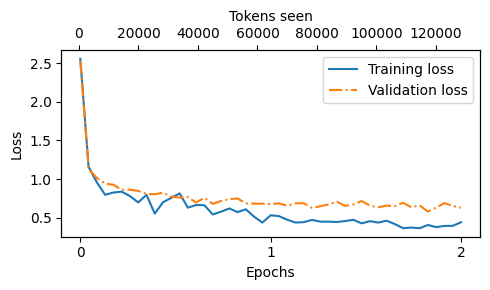

In [15]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, valid_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, valid_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, valid_losses)

In [16]:
# testing the model

for item in test_data[:3]:
    input_text = format_input(item)

    generated_tokens = text_generator.generate_text_input_text(
        text=input_text,
        max_new_tokens=256,
        eos_id=50256
    )
    response_text = text_generator.encoder.decode(generated_tokens)
    response_text = (
        response_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nExpected Response: \n\t{item['output']}")
    print(f"Model Response: \n\t{response_text.strip()}")
    print("\n-------------------------------------\n")



Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input
The car is very fast.

Expected Response: 
	The car is as fast as lightning.
Model Response: 
	The car is a fast car.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Expected Response: 
	The type of cloud typically associated with thunderstorms is cumulonimbus.
Model Response: 
	A thunderstorm is a type of thunderstorm that typically produces thunder and lightning.

-------------------------------------

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Expected Response: 
	Jane Austen.
Model Response: 
	The author of 'Pride 

In [17]:
# for all test data
from tqdm import tqdm

for i, entry in tqdm(enumerate(test_data), total=len(test_data)):

    input_text = format_input(entry)

    generated_tokens = text_generator.generate_text_input_text(
        input_text,
        max_new_tokens=256,
        eos_id=50256
    )
    response_text = text_generator.encoder.decode(generated_tokens)
    response_text = (
        response_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    test_data[i]["model_response"] = response_text


with open("./instruction_data/instruction-data-with-model-response.json", "w") as file:
    json.dump(test_data, file, indent=4)

100%|██████████| 110/110 [11:46<00:00,  6.42s/it]


In [18]:
import re

file_name = f"./weights/{re.sub(r'[ ()]', '', model_name)}-instruction.pth"
torch.save(model.state_dict(), file_name)
print(f"Saved model as {file_name}")

Saved model as ./weights/gpt2-medium355M-instruction.pth
